# Anomaly Detection in Audio

This notebook demonstrates how to detect anomalies in audio files using the CTC-SpeechRefinement package. We'll explore various techniques for identifying unusual patterns, outliers, and artifacts in audio signals.

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
# Add the project root to the Python path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
from IPython.display import Audio, display
import glob
from pathlib import Path
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Import from the project
from ctc_speech_refinement.core.preprocessing.audio import load_audio
from ctc_speech_refinement.core.eda.anomaly_detection import analyze_anomalies

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

/home/ngocducpc/miniconda3/envs/speech/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Audio Data

Let's load an audio file and examine its basic properties.

In [2]:
# Define the path to an audio file
audio_file = "../data/speech2text/input/test1_01.wav"  # Path to the audio file

# Load the audio file using our package's function
audio_data, sample_rate = load_audio(audio_file)

# Print basic information
print(f"Audio file: {audio_file}")
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {len(audio_data) / sample_rate:.2f} seconds")
print(f"Number of samples: {len(audio_data)}")

# Play the audio
display(Audio(audio_data, rate=sample_rate))

2025-05-07 15:51:06,236 - ctc_speech_refinement.core.preprocessing.audio - INFO - Loading audio file: ../data/speech2text/input/test1_01.wav
2025-05-07 15:51:07,047 - ctc_speech_refinement.core.preprocessing.audio - INFO - Loaded audio with shape (213200,) and sample rate 16000


Audio file: ../data/speech2text/input/test1_01.wav
Sample rate: 16000 Hz
Duration: 13.32 seconds
Number of samples: 213200


## Comprehensive Anomaly Detection

Let's use our package's analyze_anomalies function to perform a comprehensive analysis of anomalies in the audio.

2025-05-07 15:51:07,065 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Performing anomaly detection
2025-05-07 15:51:07,066 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Detecting amplitude anomalies with threshold 3.0
2025-05-07 15:51:07,068 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Detected 1005 amplitude anomalous regions
2025-05-07 15:51:07,069 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Detecting spectral anomalies with contamination 0.05
2025-05-07 15:51:07,201 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Detected 21 spectral anomalous frames
2025-05-07 15:51:07,201 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Plotting amplitude anomalies
2025-05-07 15:51:07,678 - ctc_speech_refinement.core.eda.anomaly_detection - INFO - Plotting spectral anomalies



Amplitude Anomalies:
Anomaly 1: 1871.00s - 1875.00s (duration: 4.00s)
Anomaly 2: 1943.00s - 1949.00s (duration: 6.00s)
Anomaly 3: 1957.00s - 1957.00s (duration: 0.00s)
Anomaly 4: 1990.00s - 1990.00s (duration: 0.00s)
Anomaly 5: 2019.00s - 2024.00s (duration: 5.00s)
Anomaly 6: 2030.00s - 2032.00s (duration: 2.00s)
Anomaly 7: 2047.00s - 2049.00s (duration: 2.00s)
Anomaly 8: 2063.00s - 2065.00s (duration: 2.00s)
Anomaly 9: 2091.00s - 2093.00s (duration: 2.00s)
Anomaly 10: 2098.00s - 2099.00s (duration: 1.00s)
Anomaly 11: 2104.00s - 2109.00s (duration: 5.00s)
Anomaly 12: 2123.00s - 2124.00s (duration: 1.00s)
Anomaly 13: 2131.00s - 2136.00s (duration: 5.00s)
Anomaly 14: 2169.00s - 2174.00s (duration: 5.00s)
Anomaly 15: 2179.00s - 2182.00s (duration: 3.00s)
Anomaly 16: 2198.00s - 2198.00s (duration: 0.00s)
Anomaly 17: 2207.00s - 2209.00s (duration: 2.00s)
Anomaly 18: 2243.00s - 2246.00s (duration: 3.00s)
Anomaly 19: 2254.00s - 2255.00s (duration: 1.00s)
Anomaly 20: 2281.00s - 2282.00s (dura

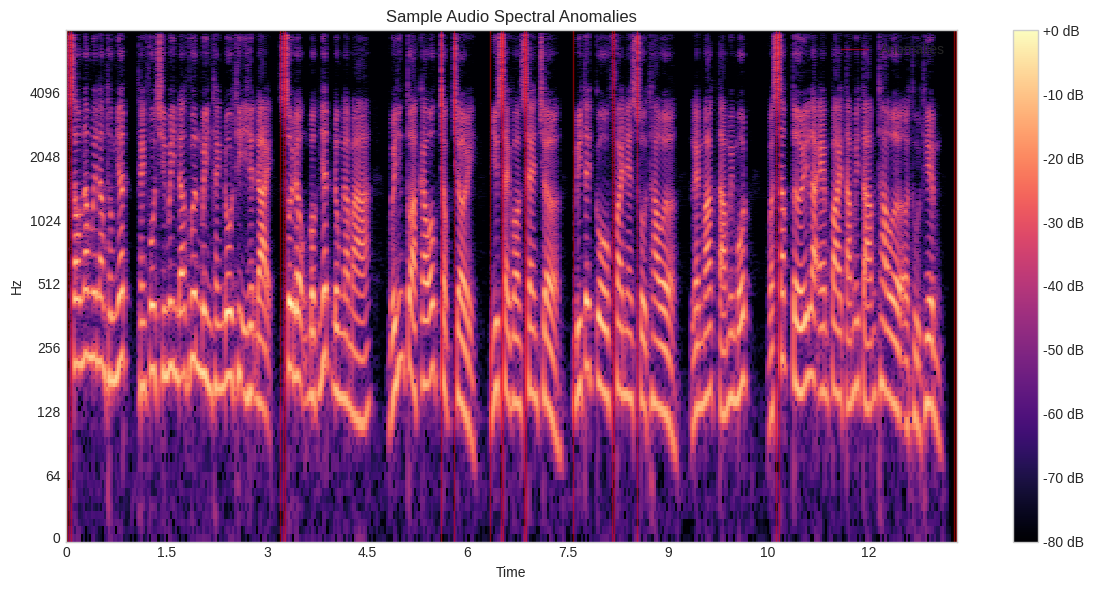

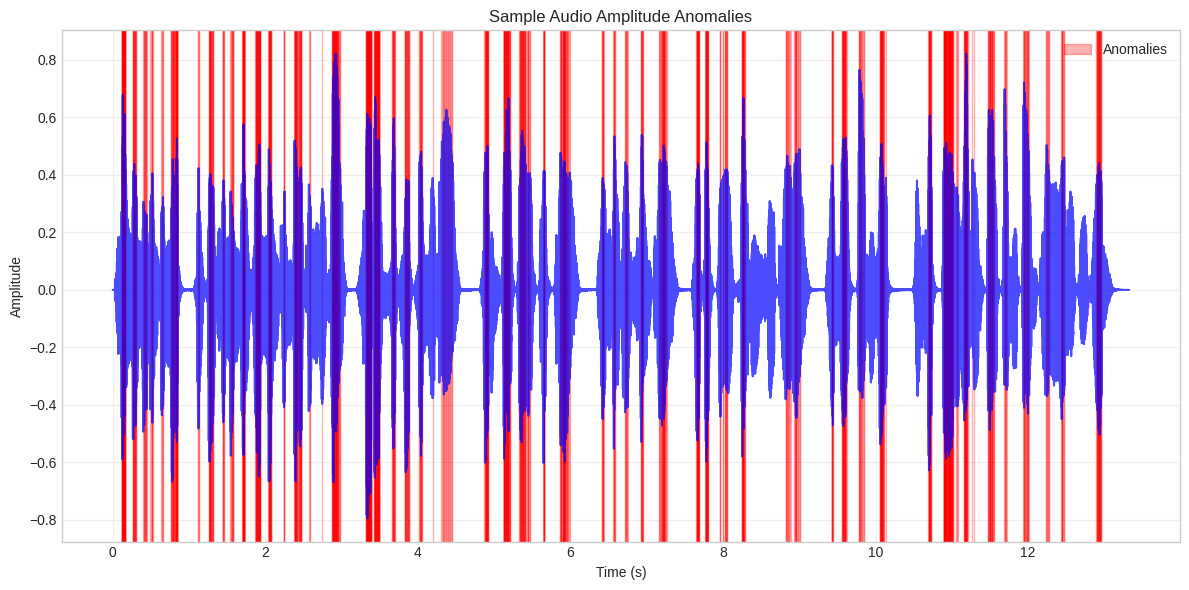

<Figure size 1200x600 with 0 Axes>

In [3]:
# Use our package's function to detect anomalies
anomaly_results = analyze_anomalies(audio_data, sample_rate, title_prefix="Sample Audio")

# Display the amplitude anomalies
print("\nAmplitude Anomalies:")
for i, (start, end) in enumerate(anomaly_results['amplitude_anomalies']):
    print(f"Anomaly {i+1}: {start:.2f}s - {end:.2f}s (duration: {end-start:.2f}s)")

# Display the spectral anomalies
print("\nSpectral Anomalies:")
for i, frame_idx in enumerate(anomaly_results['spectral_anomalies']):
    # Convert frame index to time
    time = librosa.frames_to_time(frame_idx, sr=sample_rate, hop_length=512)
    print(f"Anomaly {i+1}: at time {time:.2f}s")

# Display the figures
for fig_name, fig in anomaly_results['figures'].items():
    plt.figure(fig.number)
    plt.tight_layout()
    plt.show()

## Detailed Anomaly Detection

Now let's explore anomaly detection in more detail.

### 1. Amplitude Anomalies using Z-Score

Z-score measures how many standard deviations a data point is from the mean. We can use it to detect amplitude anomalies.

Amplitude Anomalies (Z-score method):
Anomaly 1: 0.12s - 0.12s (duration: 0.00s)
Anomaly 2: 0.12s - 0.12s (duration: 0.00s)
Anomaly 3: 0.12s - 0.12s (duration: 0.00s)
Anomaly 4: 0.12s - 0.12s (duration: 0.00s)
Anomaly 5: 0.13s - 0.13s (duration: 0.00s)
Anomaly 6: 0.13s - 0.13s (duration: 0.00s)
Anomaly 7: 0.13s - 0.13s (duration: 0.00s)
Anomaly 8: 0.13s - 0.13s (duration: 0.00s)
Anomaly 9: 0.13s - 0.13s (duration: 0.00s)
Anomaly 10: 0.13s - 0.13s (duration: 0.00s)
Anomaly 11: 0.13s - 0.13s (duration: 0.00s)
Anomaly 12: 0.13s - 0.13s (duration: 0.00s)
Anomaly 13: 0.13s - 0.13s (duration: 0.00s)
Anomaly 14: 0.14s - 0.14s (duration: 0.00s)
Anomaly 15: 0.14s - 0.14s (duration: 0.00s)
Anomaly 16: 0.14s - 0.14s (duration: 0.00s)
Anomaly 17: 0.14s - 0.14s (duration: 0.00s)
Anomaly 18: 0.14s - 0.14s (duration: 0.00s)
Anomaly 19: 0.14s - 0.14s (duration: 0.00s)
Anomaly 20: 0.14s - 0.14s (duration: 0.00s)
Anomaly 21: 0.14s - 0.14s (duration: 0.00s)
Anomaly 22: 0.15s - 0.15s (duration: 0.00s)
Ano

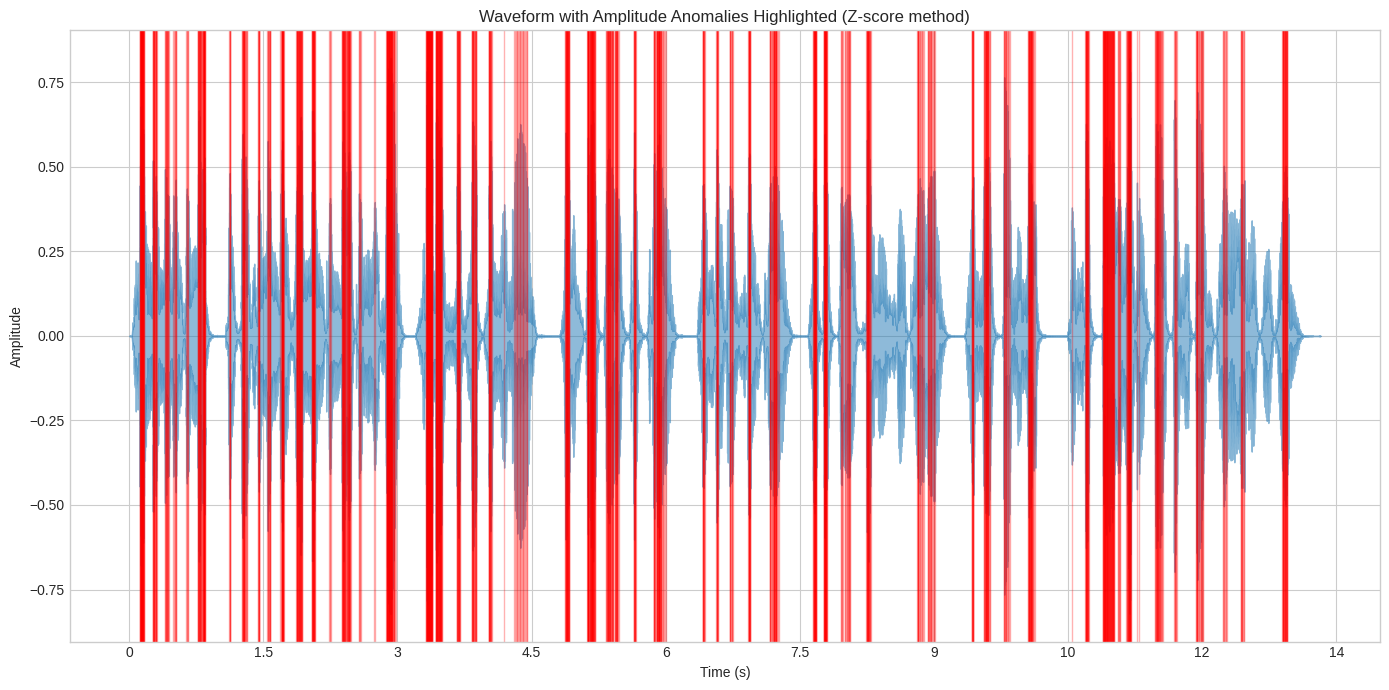

In [4]:
# Compute Z-scores for amplitude
z_scores = stats.zscore(np.abs(audio_data))

# Define threshold for anomalies
threshold = 3.0  # 3 standard deviations from the mean

# Find anomalies
anomalies = np.where(z_scores > threshold)[0]

# Group consecutive anomalies
anomaly_regions = []
if len(anomalies) > 0:
    start = anomalies[0]
    for i in range(1, len(anomalies)):
        if anomalies[i] - anomalies[i-1] > 1:  # Not consecutive
            anomaly_regions.append((start, anomalies[i-1]))
            start = anomalies[i]
    anomaly_regions.append((start, anomalies[-1]))

# Convert to time
anomaly_regions_time = [(start / sample_rate, end / sample_rate) for start, end in anomaly_regions]

# Print anomaly regions
print("Amplitude Anomalies (Z-score method):")
for i, (start, end) in enumerate(anomaly_regions_time):
    print(f"Anomaly {i+1}: {start:.2f}s - {end:.2f}s (duration: {end-start:.2f}s)")

# Plot waveform with anomalies highlighted
plt.figure(figsize=(14, 7))
librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.5)

# Highlight anomaly regions
for start, end in anomaly_regions_time:
    plt.axvspan(start, end, color='red', alpha=0.3)

plt.title('Waveform with Amplitude Anomalies Highlighted (Z-score method)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

### 2. Spectral Anomalies using Isolation Forest

Isolation Forest is an unsupervised learning algorithm that detects anomalies by isolating observations. We can use it to detect spectral anomalies.

Spectral Anomalies (Isolation Forest method):
Anomaly 1: 0.00s - 0.10s (duration: 0.10s)
Anomaly 2: 3.20s - 3.30s (duration: 0.10s)
Anomaly 3: 5.60s - 5.63s (duration: 0.03s)
Anomaly 4: 5.79s - 5.82s (duration: 0.03s)
Anomaly 5: 6.34s - 6.37s (duration: 0.03s)
Anomaly 6: 6.50s - 6.56s (duration: 0.06s)
Anomaly 7: 6.85s - 6.91s (duration: 0.06s)
Anomaly 8: 7.58s - 7.62s (duration: 0.03s)
Anomaly 9: 8.16s - 8.22s (duration: 0.06s)
Anomaly 10: 8.54s - 8.58s (duration: 0.03s)
Anomaly 11: 10.62s - 10.69s (duration: 0.06s)
Anomaly 12: 13.28s - 13.34s (duration: 0.06s)


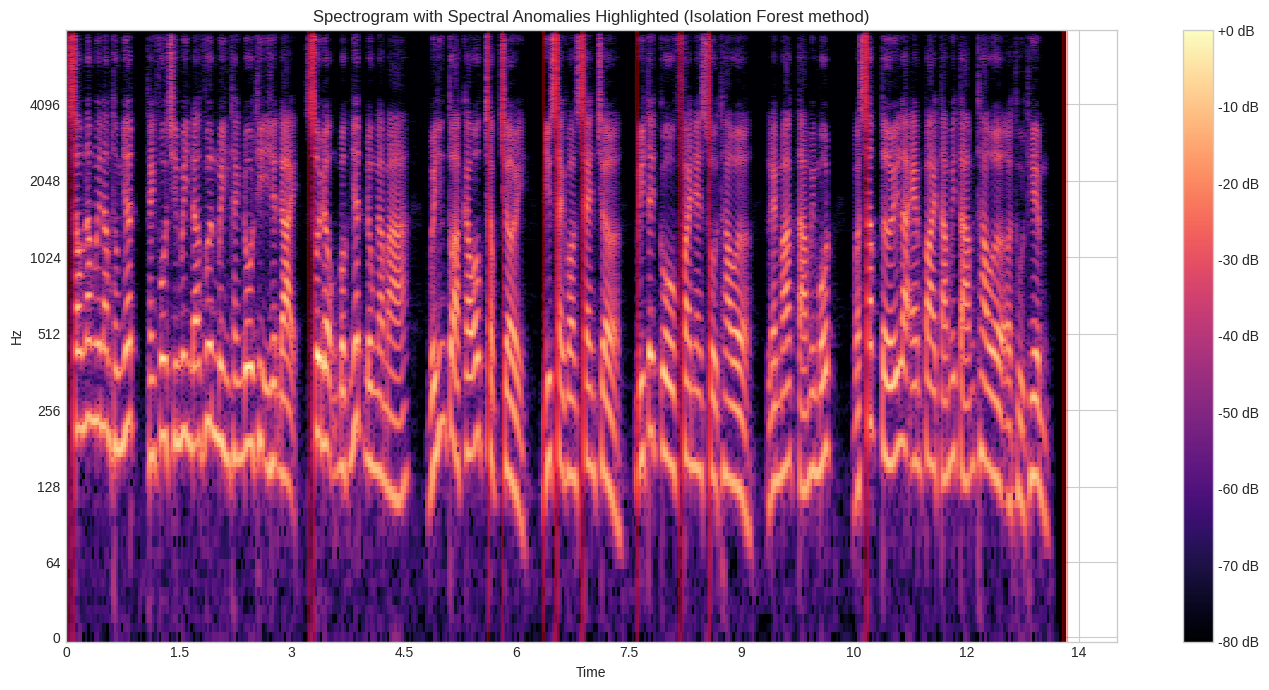

In [5]:
# Compute spectral features
hop_length = 512
frame_length = 2048

# Compute various spectral features
spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate, n_fft=frame_length, hop_length=hop_length)[0]
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate, n_fft=frame_length, hop_length=hop_length)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate, n_fft=frame_length, hop_length=hop_length)[0]
spectral_flatness = librosa.feature.spectral_flatness(y=audio_data, n_fft=frame_length, hop_length=hop_length)[0]

# Create a feature matrix
features = np.vstack([spectral_centroid, spectral_bandwidth, spectral_rolloff, spectral_flatness]).T

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply Isolation Forest
contamination = 0.05  # Expected proportion of anomalies
iso_forest = IsolationForest(contamination=contamination, random_state=42)
anomaly_scores = iso_forest.fit_predict(features_scaled)

# Convert to binary (1: normal, -1: anomaly)
anomalies = np.where(anomaly_scores == -1)[0]

# Group consecutive anomalies
anomaly_regions = []
if len(anomalies) > 0:
    start = anomalies[0]
    for i in range(1, len(anomalies)):
        if anomalies[i] - anomalies[i-1] > 1:  # Not consecutive
            anomaly_regions.append((start, anomalies[i-1]))
            start = anomalies[i]
    anomaly_regions.append((start, anomalies[-1]))

# Convert frame indices to time
anomaly_regions_time = [(start * hop_length / sample_rate, (end + 1) * hop_length / sample_rate) for start, end in anomaly_regions]

# Print anomaly regions
print("Spectral Anomalies (Isolation Forest method):")
for i, (start, end) in enumerate(anomaly_regions_time):
    print(f"Anomaly {i+1}: {start:.2f}s - {end:.2f}s (duration: {end-start:.2f}s)")

# Plot spectrogram with anomalies highlighted
plt.figure(figsize=(14, 7))

# Compute spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data, n_fft=frame_length, hop_length=hop_length)), ref=np.max)

# Plot spectrogram
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

# Highlight anomaly regions
for start, end in anomaly_regions_time:
    plt.axvspan(start, end, color='red', alpha=0.3)

plt.title('Spectrogram with Spectral Anomalies Highlighted (Isolation Forest method)')
plt.tight_layout()
plt.show()

### 3. Visualizing Anomaly Scores

Let's visualize the anomaly scores from the Isolation Forest algorithm.

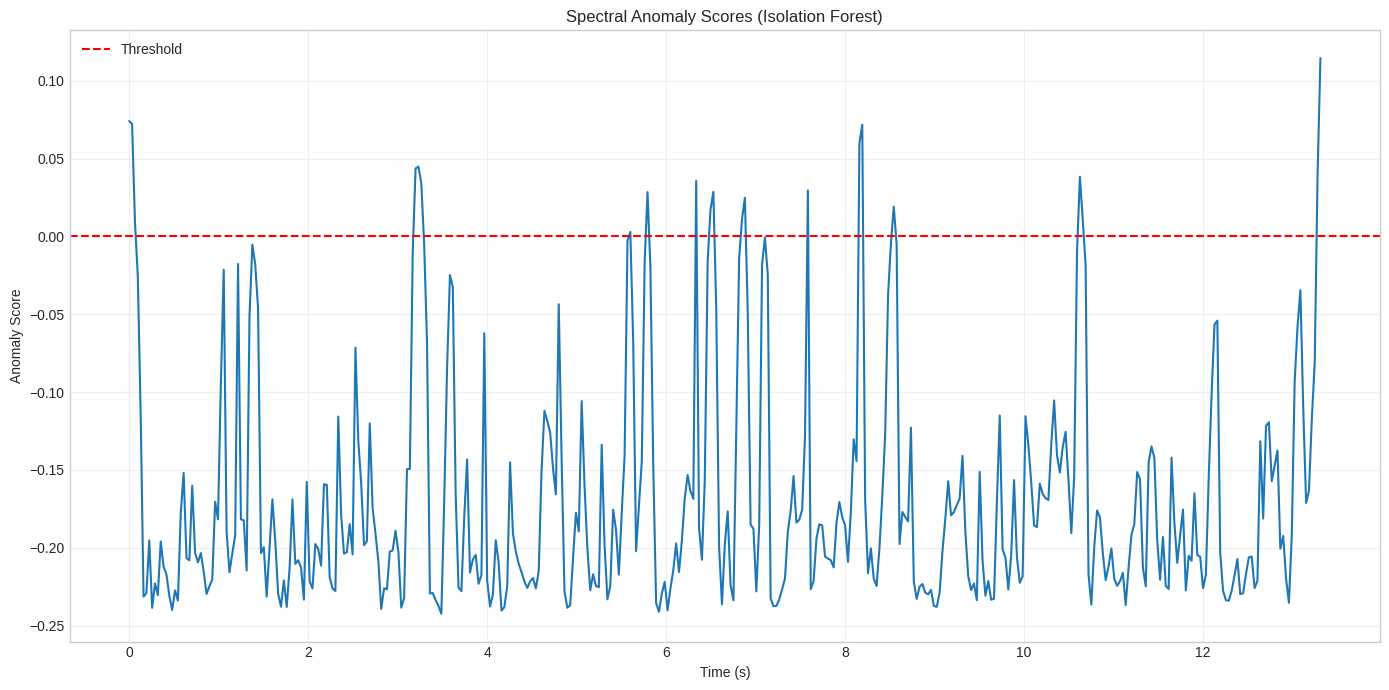

In [6]:
# Get decision function scores (higher values indicate more anomalous)
anomaly_scores_raw = -iso_forest.decision_function(features_scaled)
frame_times = librosa.frames_to_time(np.arange(len(anomaly_scores_raw)), sr=sample_rate, hop_length=hop_length)

# Plot anomaly scores
plt.figure(figsize=(14, 7))
plt.plot(frame_times, anomaly_scores_raw)
plt.axhline(y=0, color='r', linestyle='--', label='Threshold')
plt.title('Spectral Anomaly Scores (Isolation Forest)')
plt.xlabel('Time (s)')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Extracting and Playing Anomalous Segments

Let's extract and play the anomalous segments to hear what they sound like.

In [7]:
# Extract and play amplitude anomalies
print("Amplitude Anomalies:")
for i, (start, end) in enumerate(anomaly_regions_time):
    start_sample = int(start * sample_rate)
    end_sample = int(end * sample_rate)
    anomaly_segment = audio_data[start_sample:end_sample]
    
    print(f"Anomaly {i+1} ({start:.2f}s - {end:.2f}s):")
    display(Audio(anomaly_segment, rate=sample_rate))

Amplitude Anomalies:
Anomaly 1 (0.00s - 0.10s):


Anomaly 2 (3.20s - 3.30s):


Anomaly 3 (5.60s - 5.63s):


Anomaly 4 (5.79s - 5.82s):


Anomaly 5 (6.34s - 6.37s):


Anomaly 6 (6.50s - 6.56s):


Anomaly 7 (6.85s - 6.91s):


Anomaly 8 (7.58s - 7.62s):


Anomaly 9 (8.16s - 8.22s):


Anomaly 10 (8.54s - 8.58s):


Anomaly 11 (10.62s - 10.69s):


Anomaly 12 (13.28s - 13.34s):


## Conclusion

In this notebook, we've performed comprehensive anomaly detection on an audio file using the CTC-SpeechRefinement package. We've explored various techniques for detecting amplitude and spectral anomalies, including Z-score analysis and Isolation Forest. These techniques can be useful for identifying unusual patterns, outliers, and artifacts in audio signals, which is important for quality control, preprocessing, and feature extraction in speech recognition tasks.